# Variational Quantum Eigensolver Algorithm

VQE significantly enhances the efficiency of finding the ground state energy of a Hamiltonian

1. [Overview](#1.-Introduction)
2. [VQE Algorithm](#1.-Introduction)
3. [Qiskit Implementation](#3.-Quantum-Fourier-Transform)
4. [Circuit Construction](#4.-Circuit-Construction)
5. [Execution](#5.-Execution)
6. [Post Processing](#6.-Post-Processing)

## 1. Overview

#### Problem Statement

This problem involves finding the minimum eigenvalue (ground state energy) of a given Hamiltonian efficiently.
Classically, diagonalizing large Hamiltonians is computationally expensive. VQE leverages quantum computing
and classical optimization to approximate the ground state energy by combining a quantum computer, which prepares quantum states and evaluates energy expectations and a classical optimizer, which adjusts parameters to minimize the energy.

Given a parameterized Hamiltonian $H(x)$ and a parameterized quantum state $\ket{\psi(\theta)}$:


$$
H\ket{\psi(\theta)} = \ket{\psi(\theta)}x
$$ 


The goal is to estimate the lowest eigenvalue $\lambda$. VQE defines a cost function as the expected value of the Hamiltonian in the ansatz state. VQE minimizes this function to find the ground state energy and optimal quantum state.
$$
E(\theta) = \ket{{\psi(\theta)}H{\psi}(\theta)}
$$

The VQE algorithm would then iteratively run the cost function using classical optimizers to find the lowest ground state.


### VQE Steps:
1. Initialize parameters $\theta$
2. On a quantum computer:
    - Prepare state $\ket{\psi(\theta)} = U(\theta)\ket{0}$
    - Measure the energy $E(\theta)$
3. On  a classical computer, use optimizer (COBYLA, SPSA, etc.)

Repeat steps 2-3 until convergence (minimum energy found)


# 3. Qiskit Implementation

#### 3.1 Imports

In [ ]:
%pip install numpy
%pip install qiskit
%pip install matplotlib
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install qiskit[visualization]

In [4]:
# General imports
import numpy as np

# # Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
    
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
# from qiskit.primitives import Estimator, BaseEstimatorV2
from qiskit_ibm_runtime import SamplerV2, EstimatorV2
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


### Example Hamiltonian

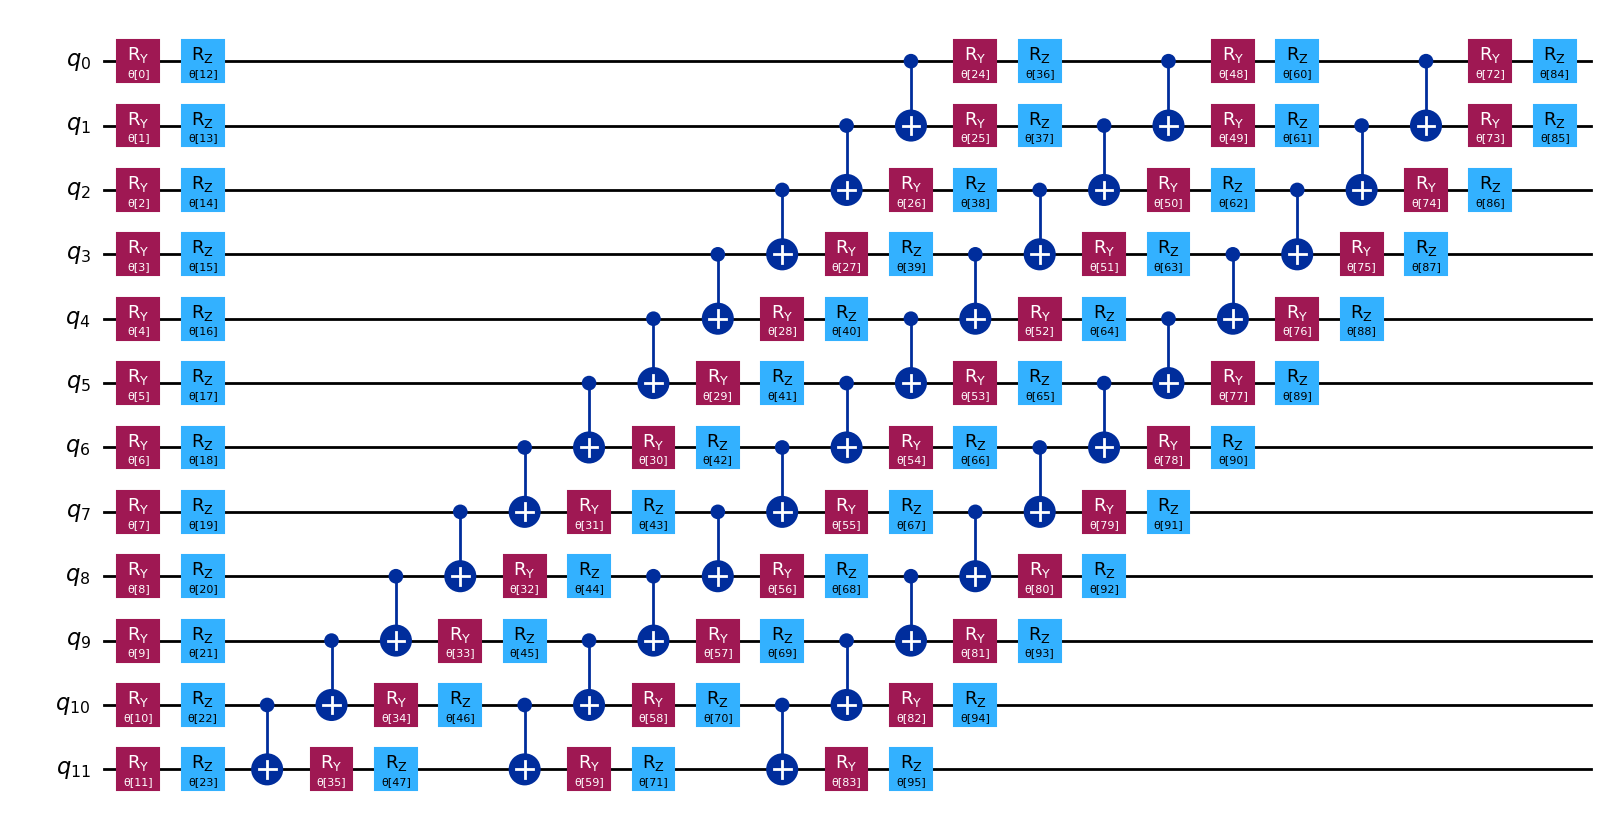

In [7]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import TwoLocal

#Example Hamiltonian 
hamiltonian = SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIIZIIZ', 'IIIIIIIZIIIZ', 'IIIIIIZIIIIZ', 'IIIIIZIIIIIZ', 'IIIIZIIIIIIZ', 'IIIZIIIIIIIZ', 'IIZIIIIIIIIZ', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIZIIZI', 'IIIIIIZIIIZI', 'IIIIIZIIIIZI', 'IIIZIIIIIIZI', 'IIZIIIIIIIZI', 'IZIIIIIIIIZI', 'IIIIZIIIIZII', 'ZIIIIIIIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 0.5+0.j, 2.5+0.j,
 2.5+0.j, 2.5+0.j, 0.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j,
 2.5+0.j, 0.5+0.j, 0.5+0.j])

ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")





In [8]:


# sets reps for VQE ansatz (Optimal Range: 2-3). 3 isn't great at finding ideal solution, stick with 2 for now
vReps = 2


# Shots for VQE sampler
vShots = 8192


maxiterVQE = 300


qubitOp = hamiltonian
vAnsatz = TwoLocal(qubitOp.num_qubits, "ry", "cz",
             reps=vReps, entanglement="linear")

hamiltonian = qubitOp


num_params = vAnsatz.num_parameters

#### Cost function

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.backend('ibm_rensselaer')
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

def cost_func(params, ansatz, hamiltonian, estimator):
    isa_circuits = pm.run(ansatz)
    pubs = (isa_circuits, hamiltonian, params)
    # cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    cost = estimator.run([pubs]).result()[0].data.evs
    # print(cost.pub_result().values[0])
    return cost

def get_cost_func(ansatz, hamiltonian, estimator):
    isa_circuits = pm.run(ansatz)
    def eval_energy(params):
        pubs = (isa_circuits, hamiltonian, params)
        energy = estimator.runestimator.run([pubs]).result()[0].data.evs

        return energy

    return eval_energy


In [1]:

import time
from time import perf_counter

from humanfriendly import format_timespan


def buildCallback(ansatz, hamiltonian, estimator, callback_dict, maxiter, testAttempts):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        """callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian,
                          parameter_values=current_vector).result().values[0]
        )"""
        isa_circuits = pm.run(ansatz)
        pubs = (isa_circuits, hamiltonian, current_vector)
        callback_dict["cost_history"].append(
            estimator.run([pubs]).result()[0].data.evs
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - \
                callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] /
                  (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )

        if callback_dict["iters"] % maxiter != 0:
            curIter = callback_dict["iters"] % maxiter
        else:
            curIter = maxiter

        # Total number of iterations for all the specified tests
        totalIter = maxiter * testAttempts
        
        testNum = (callback_dict["iters"] // maxiter) + 1

        # Determines which test is currently in progress
        if testNum != testAttempts:
            curTest = testNum
        else:
            curTest = testAttempts


        # Finds total remaining iterations for all remaining tests
        remainingIters = totalIter - callback_dict["iters"]

        # Finds how many reps until a test is complete
        iterRem = maxiter - curIter
        
        testPercent = 100*(round(curIter/maxiter, 2))
        
        ovrPercent = 100*(round(callback_dict["iters"] / totalIter, 2))

        # Estimates remaining time based on average time per iteration
        if time_str != "-":
            total_testTime = round((float(time_str) * iterRem), 0)
            total_runTime = round(
                (float(time_str) * remainingIters), 0)
            testTimeRem = format_timespan(total_testTime)
            runtimeRem = format_timespan(total_runTime)
        else:
            testTimeRem = "-"
            runtimeRem = "-"
        # Print to screen on single line
        """print(
            "Test #: [{}] Iters. done: {} / {} [Avg. time per iter: {}] [Current Test Time Remaining: {}] [Total Est. Time Remaining {}]".format(
                curTest, curIter, maxiter, time_str, testTimeRem, runtimeRem),
            end="\r",
            flush=True,
        )
        
        # Print to screen on single line
        print(
            "Test #: [{}] Iters. done: {}/{} [Avg. time per iter: {}] [{}% Complete] [Total Est. Time Remaining {}]".format(
                curTest, curIter, maxiter, time_str, testPercent, runtimeRem),
            end="\r",
            flush=True,
        )"""
        
        # Print to screen on single line
        print(
            "Overall Test: [{}/{}] Iters. done: {}/{}  [Avg. time per iter: {}] [{}% Complete] [Total Est. Time Remaining {}]".format(
                curTest, testAttempts, curIter, maxiter, time_str, ovrPercent, runtimeRem),
            end="\r",
            flush=True,
        )

    return callback

## 5. Execution

## 6. Post-Processing

In [ ]:

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
import matplotlib.pyplot as plt

# -----------------------------
# A. Construct the Hamiltonian
# -----------------------------
hamiltonian = PauliSumOp.from_list([
    ("Z", 1.0),     # Z ⊗ I
    ("IZ", 0.5),    # I ⊗ Z
    ("ZZ", 0.3)     # Z ⊗ Z
])

# -----------------------------
# B. Build the Ansatz
# -----------------------------
ansatz = TwoLocal(num_qubits=2,
                  rotation_blocks='ry',
                  entanglement_blocks='cz',
                  reps=2,
                  insert_barriers=True)

# -----------------------------
# C. Choose Optimizer
# -----------------------------
optimizer = COBYLA(maxiter=100)

# -----------------------------
# D. Backend Setup
# -----------------------------
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend=backend, shots=1024)

# -----------------------------
# E. Define Callback for Iteration Tracking
# -----------------------------
energies = []

def store_intermediate_result(eval_count, parameters, mean, std):
    energies.append(mean)
    print(f"Iteration {eval_count}: Energy = {mean:.6f}")

# -----------------------------
# F. Run VQE with Callback
# -----------------------------
vqe = VQE(ansatz=ansatz,
          optimizer=optimizer,
          quantum_instance=quantum_instance,
          callback=store_intermediate_result)

result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)

# ============================================================
# Post-Processing and Plotting
# ============================================================

print("\nFinal Estimated Ground State Energy:", result.eigenvalue.real)
print("Optimal Parameters (θ):", result.optimal_point)

# Plot energy convergence
plt.figure(figsize=(10, 6))
plt.plot(range(len(energies)), energies, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence Over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()